# Librerias

In [26]:
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt

# Explicación del modelo

Nuestra solucion de fonones se basa en un modelo 3D con aproximacion armonica, masa puntual por atomo y fuerzas centrales hasta segundos vecinos haciendo uso de la matriz dinamica. Por lo tanto las fuerzas no se tratan explicitamente, sino desde la forma general de la matriz dinamica.

Lo cual significa:
- Las fuerzas son lineales (Hay constantes de fuerza).
- Solo se consideran interacciones de:
    - Primeros vecinos
    - Segundos vecinos

La matriz dinamica contiene exactamente la misma informacion que las constantes de fuerza, pero es mucho mas facil de implementar numericamente.

$$
D^{\alpha\beta}_{ij}(\mathbf{k}) =
\frac{1}{\sqrt{m_i m_j}}
\sum_{\mathbf{R}}
\Phi^{\alpha\beta}_{ij}(\mathbf{R}) \,
e^{i\mathbf{k}\cdot\mathbf{R}}
$$

donde:

- $i, j = 1, \dots, N$ son índices atómicos.
- $\alpha, \beta \in \{x, y, z\}$ son componentes cartesianos.
- $m_i$ y $m_j$ son las masas de los átomos $i$ y $j$.
- $\mathbf{R}$ recorre todas las celdas cristalinas.
- $\Phi^{\alpha\beta}_{ij}(\mathbf{R})$ es la **constante de fuerza** que acopla el átomo $i$ en la celda origen con el átomo $j$ en la celda ubicada en $\mathbf{R}$.

Donde la matriz de constante de fuerza se define como:
$$
\boldsymbol{\Phi}_{ij}(\mathbf{R}) = 
K_{ij}(\mathbf{R})\,
\left( \hat{\mathbf{d}}_{ij} \otimes \hat{\mathbf{d}}_{ij} \right)
$$

Para el caso de las interacciones, se distinguen en color rojo aquellas correspondientes a primeros vecinos y en color verde las de segundos vecinos. Los átomos azules (átomos 1 y 2) corresponden a silicio, mientras que los átomos rosados (átomos 3 y 4) corresponden a hidrógeno. Dado que la disposición y naturaleza de las interacciones es muy similar entre las especies, se presentará un esquema únicamente para los átomos 1 y 4, ya que resultan los más sencillos de visualizar en el plano original.

![Imagen de la celda vista desde el plano xy](IMAGE\Cristal_celdas.png)

## Atomos 1 y 2

A continuación, se muestran las interacciones consideradas para el átomo 1:
![Imagen de interacciones silicio 1](IMAGE\Si1_flechitas.png)

Para facilitar su interpretación espacial, se presenta además la misma configuración en un plano que incluye el eje z:
![Imagen de interacciones silicio 1 z](IMAGE\Si1_flechitas_ang2.png)

*En esta vista es evidente que el átomo 2 posee un patrón equivalente de interacciones a segundos vecinos.*

## Atomos 3 y 4

Pasando ahora al átomo 4:

![Imagen de interacciones hidrogeno 2](IMAGE\Hi2_flechitas.png)

*De manera análoga, el átomo 3 presenta un esquema similar de interacciones a segundos vecinos.*


# Definicion de lattice y varios

In [27]:
# Definicion de lattice y bases fraccionales para hacer producto matricial y obtener coordenadas cartesianas
# (en unidades Å)
a = 3.8901956081
c = 23.7135486603
gamma = np.radians(120)
# Constantes de fuerza (en unidades eV/Å²)
force_constants = {
    "Si-Si": 5,
    "Si-H": 22,
    "2Si-H": 11
}

lattice = np.array([
    [ a, 0.0,  0.0],
    [ a * np.cos(gamma), a * np.sin(gamma) , 0.0],
    [ 0.0, 0.0,  c]
], dtype=float)

base_Si_frac = np.array([
    [2/3, 1/3, 16/33],
    [1/3, 2/3, 17/33]
], dtype=float)

base_H_frac = np.array([
    [2/3, 1/3, 0.4215227810],
    [1/3, 2/3, 0.5784772190]
], dtype=float)

# Unidades de masa atomica (uma)
mass = {
    "Si": 28.086,
    "H": 1.008
}

cell = np.concatenate([
    base_Si_frac,
    base_H_frac
]) @ lattice

# Definicion del orden de los atomos en la celda para asignar valores ij
order_i = ["Si", "Si", "H", "H"]
atom_n = len(order_i)
masses_i = np.array([mass[atom] for atom in order_i], dtype=float)
masses_ij = np.sqrt(np.tensordot(masses_i, masses_i, axes=0))
print(masses_ij)

[[28.086      28.086       5.32077889  5.32077889]
 [28.086      28.086       5.32077889  5.32077889]
 [ 5.32077889  5.32077889  1.008       1.008     ]
 [ 5.32077889  5.32077889  1.008       1.008     ]]


# Calculo de vectores $\hat{e}$

In [28]:
# Hallar los vectores e interactuantes y definir las constantes de fuerza
order_pairs = [
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-Si", "Si-Si", "Si-Si", "Si-H", "2Si-H", "2Si-H", "2Si-H"],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0],
    ["Si-H", "2Si-H", "2Si-H", "2Si-H", 0, 0, 0]
]

nested_force_cts = [
    [force_constants[atom_pair] if atom_pair != 0 else 0 for atom_pair in sublist]
    for sublist in order_pairs
]

# Convertir a un array de NumPy. Usar dtype=object permite sub-arrays de diferente longitud.
force_cts = np.array(nested_force_cts, dtype=float)

print(force_cts)

# vector final menos inicial para cada par de atomos interactuantes
R_01 = cell[1] - cell[0]
R_02 = cell[2] - cell[0]
R_03 = cell[3] - cell[0]
R_12 = cell[2] - cell[1]
R_13 = cell[3] - cell[1]

# Crear arrays para los vectores e, sus normales y los indices j
e = np.zeros((4, 7, 3), dtype=float)
e_norm = np.zeros((4, 7, 3), dtype=float)
e_jindex = np.zeros((4, 7), dtype=int)

e[0] = np.vstack([
    R_01 + lattice[0],
    R_01 - lattice[1],
    R_01,
    R_02,
    R_03 + lattice[0],
    R_03 - lattice[1],
    R_03
])

# Indices de los atomos con los que interactua el atomo 0 (Si)
e_jindex[0] = np.array([1, 1, 1, 2, 3, 3, 3])

# Normalizar cada vector fila
e_norm[0] = e[0] / np.linalg.norm(e[0], axis=1, keepdims=True)

# Repetir para el atomo 2 (Si)
e[1] = np.vstack([
    -R_01 + lattice[1],
    -R_01 - lattice[0],
    -R_01,
    R_13,
    R_12 + lattice[1],
    R_12 - lattice[0],
    R_12
])

e_jindex[1] = np.array([0, 0, 0, 3, 2, 2, 2])

# Normalizar cada vector fila
e_norm[1] = e[1] / np.linalg.norm(e[1], axis=1, keepdims=True)

e[2,0:4] = np.vstack([
    -R_02,
    -R_12 + lattice[0],
    -R_12 - lattice[1],
    -R_12
])

# Normalizar cada vector fila
e_norm[2,0:4] = e[2,0:4] / np.linalg.norm(e[2,0:4], axis=1, keepdims=True)

e_jindex[2,0:4] = np.array([0, 1, 1, 1])

e[3,0:4] = np.vstack([
    -R_13,
    -R_03 + lattice[1],
    -R_03 - lattice[0],
    -R_03
])

# Normalizar cada vector fila
e_norm[3,0:4] = e[3,0:4] / np.linalg.norm(e[3,0:4], axis=1, keepdims=True)

e_jindex[3,0:4] = np.array([1, 0, 0, 0])

[[ 5.  5.  5. 22. 11. 11. 11.]
 [ 5.  5.  5. 22. 11. 11. 11.]
 [22. 11. 11. 11.  0.  0.  0.]
 [22. 11. 11. 11.  0.  0.  0.]]


# Parametrizacion por el camino de alta simetria
Γ—M—K—Γ—A—L—H—L—M—K—Γ

In [29]:
# Definición de puntos de alta simetría (Kx, Ky, Kz)
# Puntos de alta simetria tomados de: https://seekpath.materialscloud.io/compute/process_structure/

G  = np.array([0.0,         0.0,         0.0        ])   # Gamma
M  = np.array([0.8075667576,0.4662488849,0.0        ])
K  = np.array([0.5383778384,0.9324977698,0.0        ])
A  = np.array([0.0,         0.0,         0.1324809162])
L  = np.array([0.8075667576,0.4662488849,0.1324809162])
H  = np.array([0.5383778384,0.9324977698,0.1324809162])
H2 = np.array([0.5383778384,0.9324977698,-0.1324809162])   # No usado, pero definido

# Camino de alta simetría que se va a recorrer
k_points = [G, M, K, G, A, L, H, L, M, K, G]

# Parametrización del camino
def parametrization_vec(k_points, n_points):
    path = []
    for i in range(len(k_points) - 1):
        start = k_points[i]
        end    = k_points[i + 1]
        paso  = np.linspace(start, end, n_points, endpoint=False)
        path.extend(paso)
    path.append(k_points[-1])
    return np.array(path)

n_points_segment = 100
k_path = parametrization_vec(k_points, n_points_segment)

# Obtencion de la matriz dinamica y $\omega(K)$

In [30]:
# Definir la matriz dinamica D(k) unidades eV/(Å² uma)
def dynamic_matrix(k, cell, e, e_norm, e_jindex, force_cts, masses_ij):
    N = cell.shape[0]
    D = np.zeros((3*N, 3*N), dtype=complex)

    for i in range(N):
        for l in range(7):  # Numero maximo de interacciones por atomo
            kappa = force_cts[i, l]
            if kappa == 0:
                continue

            j = e_jindex[i, l]
            e_vec = e_norm[i, l]
            R_vec = e[i, l]

            phase = np.exp(1j * np.dot(k, R_vec))

            # Construir D_ij (3x3)
            matrix_ij = -kappa * np.outer(e_vec, e_vec)
            D[i*3:(i+1)*3, j*3:(j+1)*3] += matrix_ij * phase  / masses_ij[i, j]
            D[i*3:(i+1)*3, i*3:(i+1)*3] += -matrix_ij / masses_ij[i, i]

    D = (D + D.conj().T) / 2  # Asegurar que es hermitica
    return D



# Calcular frecuencias para cada k del camino
n_k = len(k_path)
print(np.shape(k_path))
n_modes = 3 * atom_n
frequencies = np.zeros((n_k, n_modes))

for position, k_vec in enumerate(k_path):

    # Matriz dinamica para este k
    D_k = dynamic_matrix(k_vec, cell, e, e_norm, e_jindex, force_cts, masses_ij)

    # Autovalores (omega^2)
    w2, _ = eigh(D_k)
    w2 = np.real(w2) * 9.65e27  # Convertir a (rad/s)²

    # Calculo de omega unicamente con los valores reales
    w = np.zeros_like(w2)
    mascara = w2 >= 0
    w[mascara] = np.sqrt(w2[mascara])

    frequencies[position] = w


# Ordenar los modos
frequencies.sort(axis=1)

print(frequencies[0])

for i in range(3):
    if any (frequencies[:, i] > 1e-2):
        print(f"La funcion {i} es distinta a cero (máyor en algún punto a 1e-2)")

(1001, 3)
[0.00000000e+00 1.11693768e+06 4.89280218e+06 6.71113870e+13
 6.71113870e+13 1.17550748e+14 2.87677086e+14 2.87677086e+14
 2.87974667e+14 2.87974667e+14 6.05852926e+14 6.16375536e+14]
La funcion 0 es distinta a cero (máyor en algún punto a 1e-2)
La funcion 1 es distinta a cero (máyor en algún punto a 1e-2)
La funcion 2 es distinta a cero (máyor en algún punto a 1e-2)


# Grafica de dispersion

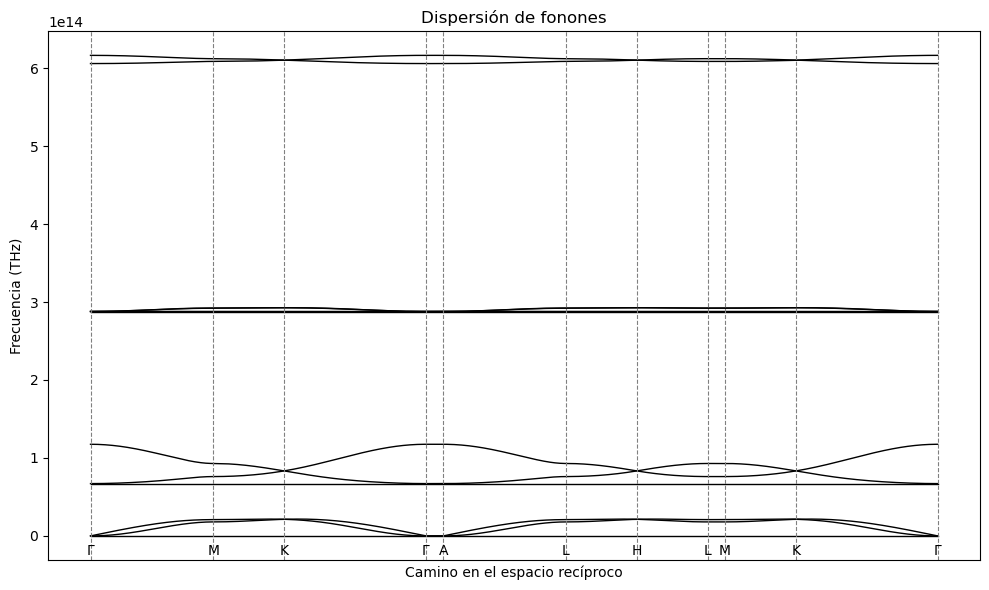

In [31]:
# Cálculo de la norma de k para graficar en función de la distancia en el espacio recíproco
dK = np.linalg.norm( np.diff(k_path, axis=0), axis=1 )
K_norm = np.concatenate(([0], np.cumsum(dK)))

# Grafico de dispersión de fonones, no tengo ni la mas remota idea de usar matplotlib, se lo pedi a chatgpt
labels = ["Γ","M","K","Γ","A","L","H","L","M","K","Γ"]
plt.figure(figsize=(10,6))
for modo in range(n_modes):
    plt.plot(K_norm, frequencies[:, modo], 'k-', linewidth=1)


for i in range(len(labels)):
    plt.axvline(K_norm[n_points_segment * i], color='gray', linestyle='--', linewidth=0.8)
    plt.text(K_norm[n_points_segment * i], -0.1e14, labels[i], ha='center', va='top')
# plt.ylim( 2.8, 3.0)
plt.title("Dispersión de fonones")
plt.ylabel("Frecuencia (THz)")
plt.xlabel("Camino en el espacio recíproco")
plt.xticks([])
plt.tight_layout()
plt.show()